# Traffic Vehicle Detection Notebook 🛣️🚗


In [2]:
# ✅ Install all required libraries for YOLOv8 and the project
!pip install torch torchvision ultralytics opencv-python matplotlib numpy pandas pillow gradio



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [3]:
# 📁 Create a directory for storing COCO dataset images (if it doesn't exist)
!mkdir -p data/coco

# 📌 Change the current working directory to the newly created COCO folder
%cd data/coco

# 🌐 Download the COCO 2017 validation images (approx. 800MB, contains 5K images)
!wget http://images.cocodataset.org/zips/val2017.zip

# 📂 Unzip the downloaded archive quietly into the current folder
!unzip -q val2017.zip



/content/data/coco
--2025-07-09 17:29:27--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.57, 3.5.27.162, 52.217.130.25, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  28.2MB/s    in 11s     

2025-07-09 17:29:39 (67.7 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [4]:
from ultralytics import YOLO
import os
from tqdm import tqdm  # For progress bars during image processing

# 🚀 Load the YOLOv8 nano model (small and fast)
model = YOLO('yolov8n.pt')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 70.5MB/s]


In [5]:
import os
import shutil
from tqdm import tqdm
from ultralytics import YOLO

# Define paths
input_dir = "val2017"  # full COCO
test_image_dir = "data/test_images"
os.makedirs(test_image_dir, exist_ok=True)

# Vehicle classes to detect
vehicle_classes = ['car', 'motorcycle', 'bus', 'truck']
valid_vehicle_images = []

# Loop through 500 images
image_list = sorted([f for f in os.listdir(input_dir) if f.endswith('.jpg')])
for image_name in tqdm(image_list[1500:1600]):  # 500 images
    image_path = os.path.join(input_dir, image_name)

    try:
        results = model(image_path, verbose=False)
        vehicle_found = False

        for r in results:
            names = r.names
            for box in r.boxes:
                cls = int(box.cls[0])
                conf = float(box.conf[0])
                label = names[cls]

                if label in vehicle_classes and conf >= 0.5:
                    vehicle_found = True
                    break
            if vehicle_found:
                break

        if vehicle_found:
            valid_vehicle_images.append(image_name)

    except Exception:
        continue

# ✅ Copy selected vehicle images to test_images folder
for img_name in valid_vehicle_images:
    shutil.copy(os.path.join(input_dir, img_name), os.path.join(test_image_dir, img_name))

print(f"\n📦 {len(valid_vehicle_images)} filtered vehicle images saved to: {test_image_dir}")



100%|██████████| 100/100 [00:11<00:00,  8.90it/s]


📦 15 filtered vehicle images saved to: data/test_images


In [6]:
import os
import cv2
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm

# Paths for your folders
input_dir = "data/test_images"  # ✅ use your filtered test images
output_dir = "output/processed_images"
os.makedirs(output_dir, exist_ok=True)

# Function to process each image
def process_and_save_image(image_path, model, output_path):
    results = model(image_path, verbose=False)

    if not results or not hasattr(results[0], 'boxes') or results[0].boxes is None:
        return {'car': 0, 'motorcycle': 0, 'bus': 0, 'truck': 0}

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    counts = {cls: 0 for cls in vehicle_classes}

    # 🎨 Define clear BGR colors for each class
    colors = {
        'car': (255, 0, 0),         # Blue
        'motorcycle': (0, 255, 0),  # Green
        'bus': (0, 165, 255),       # Orange
        'truck': (203, 192, 255)    # Pinkish
    }

    for r in results:
        for box in r.boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            label = r.names[cls_id]

            if label in counts:
                counts[label] += 1
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                label_text = f"{label} {conf:.2f}"
                color = colors.get(label, (255, 255, 255))  # fallback white

                # 🖍️ Draw box and label
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                cv2.putText(img, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, color, 2)

    # Convert back to BGR before saving
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # 📋 Prepare one-line summary text
    summary_text = f"Total: {sum(counts.values())}   "
    summary_text += "   ".join([f"{k.capitalize()}: {v}" for k, v in counts.items()])

    # Add to bottom-left of image
    cv2.putText(img, summary_text, (10, img.shape[0] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

    # Save final annotated image
    filename = os.path.basename(image_path)
    save_path = os.path.join(output_path, filename)
    cv2.imwrite(save_path, img)

    return counts



# Setup CSV file to store counts
csv_path = "output/vehicle_counts_summary.csv"
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_name', 'car', 'motorcycle', 'bus', 'truck', 'total_vehicles'])

# Process each image in test_images
image_list = sorted([f for f in os.listdir(input_dir) if f.endswith('.jpg')])

for img_name in tqdm(image_list):
    img_path = os.path.join(input_dir, img_name)
    counts = process_and_save_image(img_path, model, output_dir)

    row = [
        img_name,
        counts['car'],
        counts['motorcycle'],
        counts['bus'],
        counts['truck'],
        sum(counts.values())
    ]

    with open(csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)

print(f"\n✅ Annotated images saved to: {output_dir}")
print(f"📄 CSV summary saved to: {csv_path}")


100%|██████████| 15/15 [00:00<00:00, 43.63it/s]


✅ Annotated images saved to: output/processed_images
📄 CSV summary saved to: output/vehicle_counts_summary.csv


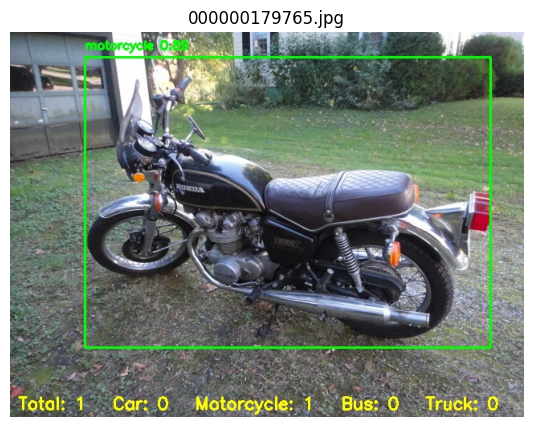

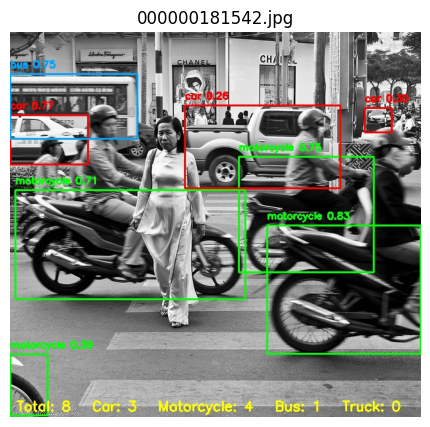

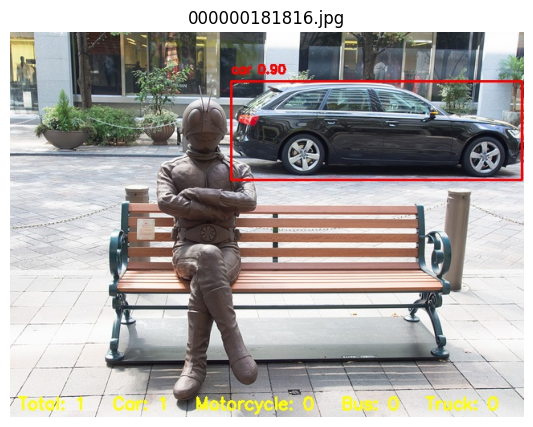

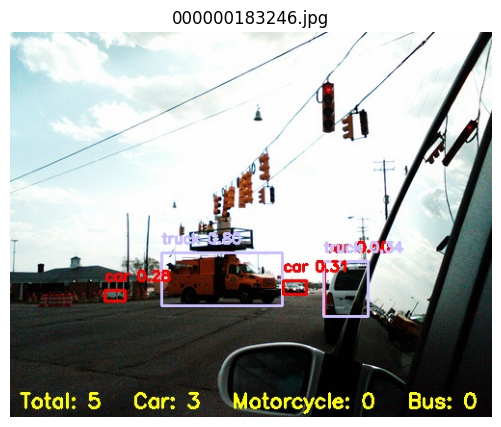

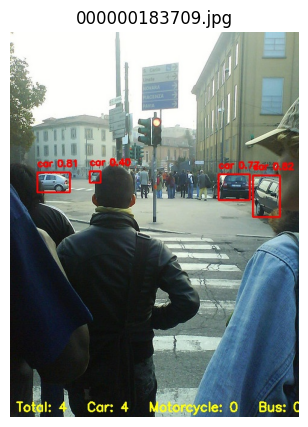

In [7]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to annotated images
output_dir = "output/processed_images"

# Pick first 5 images from output folder
output_images = sorted([f for f in os.listdir(output_dir) if f.endswith('.jpg')])[10:15]

# Display them
for img_name in output_images:
    img_path = os.path.join(output_dir, img_name)
    img = cv2.imread(img_path)

    if img is None:
        print(f"⚠️ Could not read {img_name}")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 5))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(img_name)
    plt.show()


In [8]:
import pandas as pd

# Load the vehicle count summary CSV into a DataFrame
counts_df = pd.read_csv(csv_path)

# Get the first 5 rows
sample_counts = counts_df.head(5).to_dict('records')

print("📊 Vehicle Detection Summary:\n")

# Loop through each entry in the summary and print detailed counts
for entry in sample_counts:
    img_name = entry.get("image_name", "unknown")
    car_count = entry.get("car", 0)
    motorcycle_count = entry.get("motorcycle", 0)
    bus_count = entry.get("bus", 0)
    truck_count = entry.get("truck", 0)
    total = entry.get("total_vehicles", 0)

    # Print all counts for this image
    print(f"🖼️ {img_name} → Total: {total} | Cars: {car_count}, Motorcycles: {motorcycle_count}, Buses: {bus_count}, Trucks: {truck_count}")



📊 Vehicle Detection Summary:

🖼️ 000000174004.jpg → Total: 1 | Cars: 0, Motorcycles: 0, Buses: 0, Trucks: 1
🖼️ 000000174482.jpg → Total: 10 | Cars: 9, Motorcycles: 0, Buses: 0, Trucks: 1
🖼️ 000000175438.jpg → Total: 15 | Cars: 15, Motorcycles: 0, Buses: 0, Trucks: 0
🖼️ 000000176037.jpg → Total: 1 | Cars: 0, Motorcycles: 0, Buses: 1, Trucks: 0
🖼️ 000000176606.jpg → Total: 2 | Cars: 2, Motorcycles: 0, Buses: 0, Trucks: 0


In [12]:
import gradio as gr
import numpy as np
import pandas as pd
from ultralytics import YOLO
import cv2
import os
from PIL import Image

# Load YOLOv8 model
model = YOLO("yolov8n.pt")

vehicle_types = ["car", "truck", "motorcycle"]
colors = {
    "car": (0, 255, 0),         # Green
    "truck": (0, 0, 255),       # Red
    "motorcycle": (255, 0, 0)   # Blue
}

output_dir = "output/processed_images"
os.makedirs(output_dir, exist_ok=True)

# ---------- IMAGE HANDLER ----------
def detect_images(images):
    annotated_images = []
    summary_data = []

    for idx, image_file in enumerate(images):
        image = Image.open(image_file.name)
        image_np = np.array(image)

        results = model.predict(image_np)
        boxes = results[0].boxes
        names = results[0].names

        counts = {v: 0 for v in vehicle_types}

        # Draw detections manually with colored boxes
        annotated_img = image_np.copy()
        if boxes is not None:
            for i in range(len(boxes)):
                cls_id = int(boxes.cls[i].item())
                conf = float(boxes.conf[i].item())
                label = names[cls_id]

                if label in vehicle_types:
                    counts[label] += 1
                    x1, y1, x2, y2 = map(int, boxes.xyxy[i])
                    color = colors[label]
                    label_text = f"{label} {conf:.2f}"
                    cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(annotated_img, label_text, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        total = sum(counts.values())
        summary_text = f"Total: {total}  Cars: {counts['car']}  Trucks: {counts['truck']}  Motorcycles: {counts['motorcycle']}"
        cv2.putText(annotated_img, summary_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

        save_name = f"image_{idx+1}.jpg"
        save_path = os.path.join(output_dir, save_name)
        cv2.imwrite(save_path, cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))

        summary_data.append({
            "Image": save_name,
            "Cars": counts["car"],
            "Trucks": counts["truck"],
            "Motorcycles": counts["motorcycle"],
            "Total Vehicles": total
        })

        annotated_images.append(save_path)


    df = pd.DataFrame(summary_data)
    return annotated_images, df

# ---------- VIDEO HANDLER ----------
def detect_video(video_file):
    temp_input_path = video_file.name
    temp_output_path = os.path.join(output_dir, "output_video.mp4")

    cap = cv2.VideoCapture(temp_input_path)
    width = int(cap.get(3))
    height = int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(temp_output_path, fourcc, fps, (width, height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.predict(frame)
        boxes = results[0].boxes
        names = results[0].names

        if boxes is not None:
            for i in range(len(boxes)):
                cls_id = int(boxes.cls[i].item())
                conf = float(boxes.conf[i].item())
                label = names[cls_id]

                if label in colors:
                    x1, y1, x2, y2 = map(int, boxes.xyxy[i])
                    color = colors[label]
                    label_text = f"{label} {conf:.2f}"
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(frame, label_text, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        out.write(frame)

    cap.release()
    out.release()

    return temp_output_path

# ---------- INTERFACE ----------
with gr.Blocks(theme=gr.themes.Base(primary_hue="orange", secondary_hue="blue")) as demo:
    gr.Markdown("""
    # 🚦 Traffic Vehicle Detection System (YOLOv8)""")

    with gr.Tab("🖼️ Image Upload"):
        img_input = gr.File(file_types=[".jpg", ".png"], file_count="multiple", label="Upload Traffic Images")
        img_button = gr.Button("🔍 Detect Vehicles (Images)")
        img_output = gr.Gallery(label="Detection Results", height=300)
        table_output = gr.Dataframe(label="Vehicle Count Summary")

    with gr.Tab("🎥 Video Upload"):
        video_input = gr.File(file_types=[".mp4", ".mov", ".avi"], label="Upload Traffic Video")
        video_button = gr.Button("🔍 Detect Vehicles (Video)")
        video_output = gr.Video(label="Processed Video")

    img_button.click(fn=detect_images, inputs=img_input, outputs=[img_output, table_output])
    video_button.click(fn=detect_video, inputs=video_input, outputs=video_output)

demo.launch(debug=False)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://916cec77ee59c3967a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
